Training PPO agent...
Episode 0, Average Reward: -105.33
Episode 100, Average Reward: -110.21
Episode 200, Average Reward: -106.75
Episode 300, Average Reward: -105.93
Episode 400, Average Reward: -94.60
Episode 500, Average Reward: -91.53
Episode 600, Average Reward: -87.76
Episode 700, Average Reward: -83.20
Episode 800, Average Reward: -69.85
Episode 900, Average Reward: -69.60

Plotting training progress...


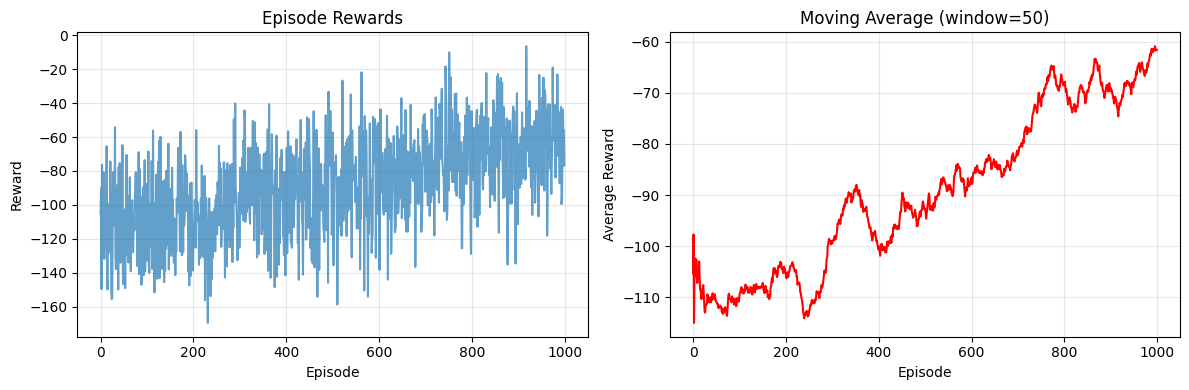


Evaluating agent...
Evaluation - Mean: -64.48, Std: 26.56


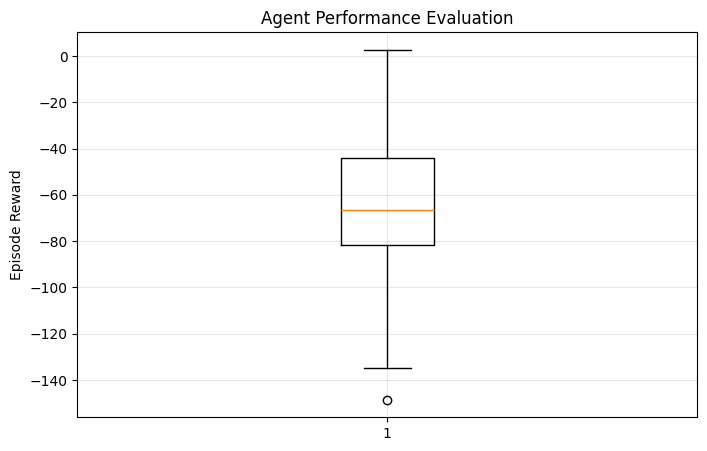

In [3]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

# Set seed for reproducibility
torch.manual_seed(2021)
np.random.seed(2021)

# Environment functions
def create_env():
    """Create supply chain environment"""
    return {
        'state_size': 15,
        'action_size': 6,
        'max_steps': 25,
        'step_count': 0,
        'state': np.random.uniform(-1, 1, 15)
    }

def reset_env(env):
    """Reset environment"""
    env['step_count'] = 0
    env['state'] = np.random.uniform(-1, 1, env['state_size'])
    return env['state'].copy()

def step_env(env, action):
    """Step environment"""
    env['step_count'] += 1
    
    # Add dynamics and noise
    env['state'] += np.random.normal(0, 0.1, env['state_size'])
    env['state'] = np.clip(env['state'], -2, 2)
    
    # Calculate reward
    reward = -np.sum(action**2) + np.sum(env['state'][:2]) - 0.1 * env['step_count']
    done = env['step_count'] >= env['max_steps']
    
    return env['state'].copy(), reward, done

# Network functions
def create_network(state_size, action_size, hidden_size=64):
    """Create PPO network"""
    shared = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU()
    )
    actor_mean = nn.Linear(hidden_size, action_size)
    actor_std = nn.Linear(hidden_size, action_size)
    critic = nn.Linear(hidden_size, 1)
    
    return {
        'shared': shared,
        'actor_mean': actor_mean,
        'actor_std': actor_std,
        'critic': critic
    }

def forward_network(network, state):
    """Forward pass through network"""
    x = network['shared'](state)
    action_mean = network['actor_mean'](x)
    action_std = F.softplus(network['actor_std'](x)) + 1e-5
    value = network['critic'](x)
    return action_mean, action_std, value

# Agent functions
def create_agent(state_size, action_size, lr=3e-4):
    """Create PPO agent"""
    network = create_network(state_size, action_size)
    
    # Get all parameters
    params = (list(network['shared'].parameters()) + 
              list(network['actor_mean'].parameters()) + 
              list(network['actor_std'].parameters()) + 
              list(network['critic'].parameters()))
    
    optimizer = optim.Adam(params, lr=lr)
    
    agent = {
        'network': network,
        'optimizer': optimizer,
        'gamma': 0.99,
        'eps_clip': 0.2,
        'k_epochs': 4,
        'states': [],
        'actions': [],
        'log_probs': [],
        'rewards': [],
        'values': [],
        'dones': []
    }
    return agent

def get_action(agent, state):
    """Get action from agent"""
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_mean, action_std, value = forward_network(agent['network'], state)
        dist = Normal(action_mean, action_std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
    return action.squeeze().numpy(), log_prob.item(), value.item()

def store_transition(agent, state, action, log_prob, reward, value, done):
    """Store transition in agent buffer"""
    agent['states'].append(state)
    agent['actions'].append(action)
    agent['log_probs'].append(log_prob)
    agent['rewards'].append(reward)
    agent['values'].append(value)
    agent['dones'].append(done)

def update_agent(agent):
    """Update PPO agent"""
    if len(agent['states']) == 0:
        return 0
    
    # Convert to tensors
    states = torch.FloatTensor(agent['states'])
    actions = torch.FloatTensor(agent['actions'])
    old_log_probs = torch.FloatTensor(agent['log_probs'])
    
    # Calculate returns
    returns = []
    R = 0
    for i in reversed(range(len(agent['rewards']))):
        R = agent['rewards'][i] + agent['gamma'] * R * (1 - agent['dones'][i])
        returns.insert(0, R)
    
    returns = torch.FloatTensor(returns)
    values = torch.FloatTensor(agent['values'])
    advantages = returns - values
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    total_loss = 0
    for _ in range(agent['k_epochs']):
        action_means, action_stds, values = forward_network(agent['network'], states)
        dist = Normal(action_means, action_stds)
        new_log_probs = dist.log_prob(actions).sum(dim=-1)
        
        ratio = torch.exp(new_log_probs - old_log_probs)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - agent['eps_clip'], 1 + agent['eps_clip']) * advantages
        
        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = F.mse_loss(values.squeeze(), returns)
        loss = actor_loss + 0.5 * critic_loss
        
        agent['optimizer'].zero_grad()
        loss.backward()
        agent['optimizer'].step()
        total_loss += loss.item()
    
    clear_buffer(agent)
    return total_loss / agent['k_epochs']

def clear_buffer(agent):
    """Clear agent buffer"""
    agent['states'] = []
    agent['actions'] = []
    agent['log_probs'] = []
    agent['rewards'] = []
    agent['values'] = []
    agent['dones'] = []

def train_ppo(episodes=1000, update_freq=20):
    """Train PPO agent"""
    env = create_env()
    agent = create_agent(env['state_size'], env['action_size'])
    episode_rewards = []
    
    for episode in range(episodes):
        state = reset_env(env)
        episode_reward = 0
        
        for step in range(env['max_steps']):
            action, log_prob, value = get_action(agent, state)
            action = np.clip(action, -2, 2)  # Clip actions
            
            next_state, reward, done = step_env(env, action)
            store_transition(agent, state, action, log_prob, reward, value, done)
            
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        
        # Update agent
        if (episode + 1) % update_freq == 0:
            loss = update_agent(agent)
        
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")
    
    return agent, episode_rewards

def plot_results(episode_rewards):
    """Plot training results"""
    plt.figure(figsize=(12, 4))
    
    # Episode rewards
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, alpha=0.7)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True, alpha=0.3)
    
    # Moving average
    plt.subplot(1, 2, 2)
    window = 50
    moving_avg = [np.mean(episode_rewards[max(0, i-window):i+1]) 
                  for i in range(len(episode_rewards))]
    plt.plot(moving_avg, color='red')
    plt.title(f'Moving Average (window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_agent(agent, episodes=100):
    """Evaluate trained agent"""
    env = create_env()
    rewards = []
    
    for _ in range(episodes):
        state = reset_env(env)
        episode_reward = 0
        
        for _ in range(env['max_steps']):
            action, _, _ = get_action(agent, state)
            action = np.clip(action, -2, 2)
            state, reward, done = step_env(env, action)
            episode_reward += reward
            if done:
                break
        
        rewards.append(episode_reward)
    
    print(f"Evaluation - Mean: {np.mean(rewards):.2f}, Std: {np.std(rewards):.2f}")
    
    plt.figure(figsize=(8, 5))
    plt.boxplot(rewards)
    plt.title('Agent Performance Evaluation')
    plt.ylabel('Episode Reward')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return rewards

if __name__ == "__main__":
    print("Training PPO agent...")
    agent, episode_rewards = train_ppo(episodes=1000)
    
    print("\nPlotting training progress...")
    plot_results(episode_rewards)
    
    print("\nEvaluating agent...")
    eval_rewards = evaluate_agent(agent, episodes=100)